In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!ls "/content/drive/My Drive/DEBI/nlp/Group_project/Assignment_2"
# !python3 "/content/drive/My Drive/DEBI/Ottawa/Data Science Applications/Assignments/Group_project/Assignment_2/cluster_evaluate.py"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# %cd "/content/drive/My Drive/DEBI/Ottawa/Data Science Applications/Assignments/Group_project/Assignment_2/cluster_evaluate.py"

[Errno 20] Not a directory: '/content/drive/My Drive/DEBI/Ottawa/Data Science Applications/Assignments/Group_project/Assignment_2/cluster_evaluate.py'
/content


In [ ]:
import pandas as pd
import nltk
import re
from tqdm import tqdm as tq
import spacy
import string
from nltk.corpus import stopwords
import string
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def book_pagination(book, book_name, author, title, cluster_no):
    """
    Partitioning(pagination) of the book to take each 150 word with the label/book_name for each partition.
    """
    tokenized_words=nltk.word_tokenize(book)
    tokenized_words = [w for w in tokenized_words if not w.lower() in stop_words]
    offset = 0
    pages = []
    for i in range(1, min(int(np.floor(len(tokenized_words)/150.0)), 200)):
        limit = i*150
        pages.append({'book_name': book_name,
                      'partition': " ".join(tokenized_words[offset:limit]),
                      'author': author,
                      'title': title,
                      'cluster_No': cluster_no})
        offset = limit 
    return pages

def clean_text(text):
  ## 1. Lowercase the text
  text = text.lower() 

  ## 2. Remove Punctuations
  text = text.translate(str.maketrans('', '', string.punctuation)) 
  
  ## 3. Tokenize all the words
  words = nltk.word_tokenize(text)

  ## 4. Remove stopwords and word digits
  clean_text = " ".join([ w for w in words if w.isalnum() ])
  clean_text = clean_text.replace("\t", ' ')
  # clean_text = " ".join([ w for w in words if w.isalnum() and (w not in stop_words)  ])
  return clean_text

In [ ]:
import json

In [ ]:
books = [
         {'file': 'austen-emma.txt' , 'url': "https://www.gutenberg.org/ebooks/158",
          'author': 'Jane Austen', 'genre': 'Fiction', 'title': 'Emma', 'Cluster_No':'0'},
         
         {'file': 'blake-poems.txt', 'url':'https://www.gutenberg.org/ebooks/574',
          'author': 'William Blake', 'genre': 'Poetry', 'title': 'Poems of William Blake','Cluster_No':'1'},
         
         {'file': 'shakespeare-hamlet.txt', 'url':'https://www.gutenberg.org/ebooks/1787',
          'author': 'William Shakespeare', 'genre': 'Drama', 'title': 'Hamlet','Cluster_No':'2'},
         
         {'file': 'carroll-alice.txt', 'url':'https://www.gutenberg.org/ebooks/35688',
         'author': 'Lewis Carroll and Alice Gerstenberg', 'genre': 'Fantasy Drama', 'title': 'Alice in Wonderland','Cluster_No':'3'},
         
         {'file': 'edgeworth-parents.txt', 'url':'https://www.gutenberg.org/ebooks/36132',
          'author': 'Maria Edgeworth', 'genre': "Children's stories", 'title': "The Parent's Assistant; Or, Stories for Children",'Cluster_No':'4'}]

with open('books.json', 'w') as jf:
  json.dump(books, jf)

In [ ]:
books = pd.read_json('books.json')

In [ ]:
book_pages = []

for ind,bk in tq(books.iterrows(), total= books.shape[0]):
  book = nltk.corpus.gutenberg.raw(bk['file'])
  clean_book = clean_text(book) ## Regex to clean the text and tokenize it
  mydict=book_pagination(clean_book, bk['file'].split('.txt')[0], bk['author'], bk['title'], bk['Cluster_No'])
  book_pages+=mydict

books_df = pd.DataFrame(book_pages)

100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


# Feature Extraction 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer, TfidfTransformer

TF-iDF & BOW

In [ ]:
#TF-iDF
tfidf_vec = TfidfVectorizer()
tfidf = tfidf_vec.fit_transform(books_df.partition.values)

#BOW
bow_vec = CountVectorizer()
bow = bow_vec.fit_transform(books_df.partition.values)

# Choosing the best n_components according the Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import silhouette_samples, silhouette_score
import math

In [ ]:
def n_components(features):
  sklearn_pca = PCA(n_components = 2)
  Y_sklearn = sklearn_pca.fit_transform(features.toarray())
  n_components = np.arange(1, 21)
  models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Y_sklearn)
          for n in n_components]

  plt.plot(n_components, [m.bic(Y_sklearn) for m in models], label='BIC')
  plt.plot(n_components, [m.aic(Y_sklearn) for m in models], label='AIC')
  plt.legend(loc='best')
  plt.xlabel('n_components');


# Gaussian Model on TFiDF

**Decide the n_components based on the AIC and BIC**

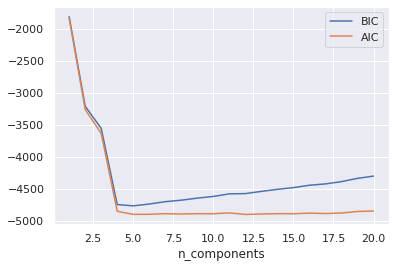

In [ ]:
n_components(tfidf)

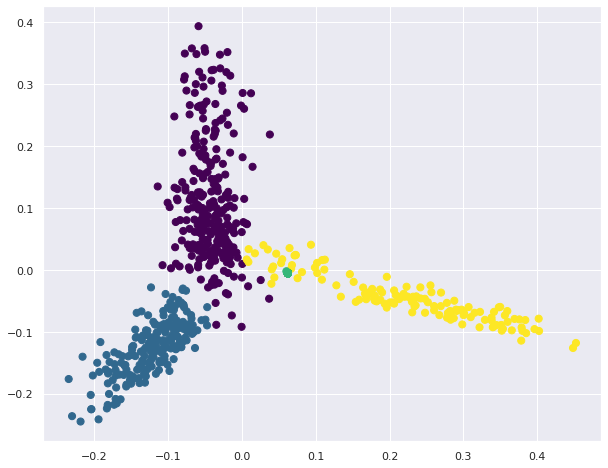

In [ ]:
# Reduce feacture vectors using PCA to 2-components 2D
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tfidf.toarray())
#n_components relate to number of clusters n_components=9 according to the AIC & BIC method
gmm = GaussianMixture(n_components=4, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')





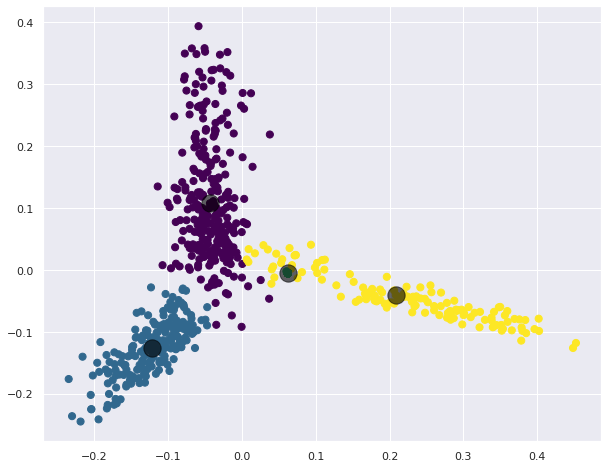

In [ ]:
#Highlight the centroid position for each cluster
centers = np.zeros((4,2))
for i in range(4):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

**Human vs Model**

Compare and decide which clustering result is the closest to the human labels, according to the highest percent means the best cluster according to the actual clusters

In [ ]:
get_clusters_label(prediction_gmm,books_df.book_name)

actual_labels
clusters actual_labels                    
0        edgeworth-parents       68.100358
         carroll-alice           30.465950
         austen-emma              1.075269
         blake-poems              0.358423
1        austen-emma             97.512438
         edgeworth-parents        2.487562
2        shakespeare-hamlet      50.000000
         carroll-alice           39.215686
         blake-poems             10.784314
3        shakespeare-hamlet      79.104478
         blake-poems             17.910448
         edgeworth-parents        2.985075

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(prediction_gmm,books_df.book_name)))

,cluster,label,percentage
0,0,edgeworth-parents,68.100358
1,1,austen-emma,97.512438
2,3,shakespeare-hamlet,79.104478


**Error Analysis**

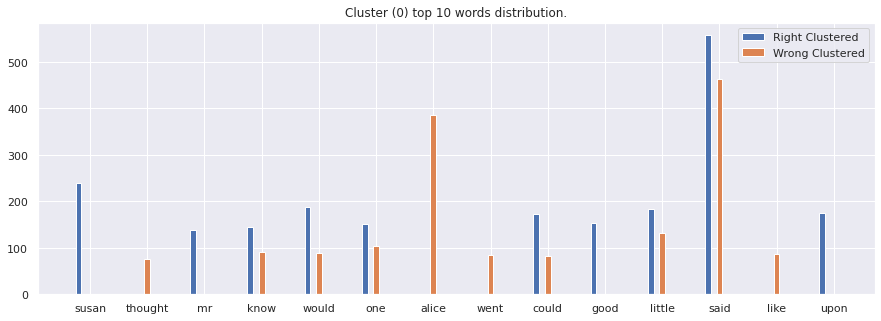

Top 10 words in the right clustered
 [('said', 557), ('susan', 239), ('would', 187), ('little', 183), ('upon', 175), ('could', 173), ('good', 154), ('one', 151), ('know', 144), ('mr', 138)]

Top 10 words in the wrong clustered
 [('said', 464), ('alice', 385), ('little', 131), ('one', 103), ('know', 90), ('would', 88), ('like', 87), ('went', 85), ('could', 82), ('thought', 76)]

Found 6 words in both right and wrong clustered top words [('said', 464), ('little', 131), ('one', 103), ('know', 90), ('would', 88), ('could', 82)]




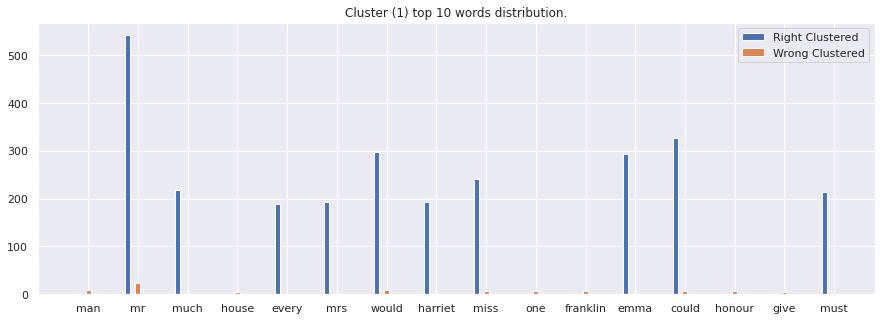

Top 10 words in the right clustered
 [('mr', 541), ('could', 327), ('would', 298), ('emma', 294), ('miss', 242), ('much', 218), ('must', 214), ('mrs', 192), ('harriet', 192), ('every', 189)]

Top 10 words in the wrong clustered
 [('mr', 24), ('would', 10), ('man', 10), ('could', 7), ('miss', 7), ('honour', 7), ('one', 6), ('franklin', 6), ('house', 5), ('give', 5)]

Found 4 words in both right and wrong clustered top words [('mr', 24), ('would', 10), ('could', 7), ('miss', 7)]




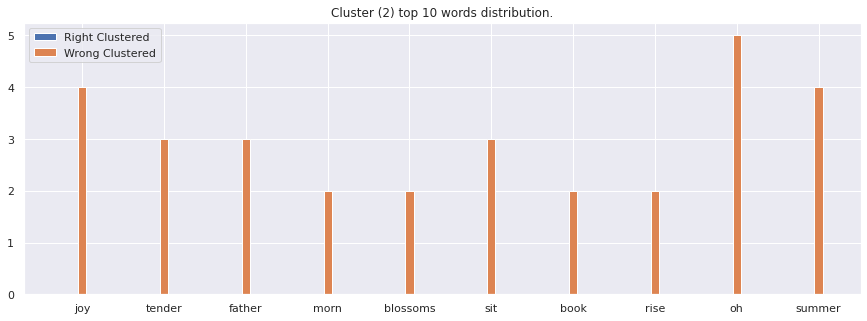

Top 10 words in the right clustered
 []

Top 10 words in the wrong clustered
 [('oh', 5), ('summer', 4), ('joy', 4), ('father', 3), ('tender', 3), ('sit', 3), ('book', 2), ('blossoms', 2), ('rise', 2), ('morn', 2)]

Found 0 words in both right and wrong clustered top words []




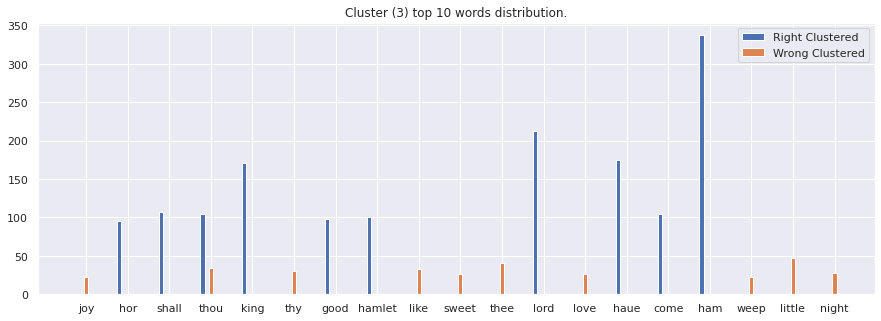

Top 10 words in the right clustered
 [('ham', 337), ('lord', 212), ('haue', 175), ('king', 171), ('shall', 107), ('thou', 105), ('come', 104), ('hamlet', 100), ('good', 98), ('hor', 95)]

Top 10 words in the wrong clustered
 [('little', 47), ('thee', 41), ('thou', 34), ('like', 33), ('thy', 30), ('night', 28), ('love', 27), ('sweet', 26), ('weep', 23), ('joy', 22)]

Found 1 words in both right and wrong clustered top words [('thou', 34)]




In [ ]:
top_frequent_analysis(prediction_gmm,books_df.book_name,books_df.partition)

/content/cluster_evaluate.py:129: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(all_label_dist_df[[i for i in range(0,num_clusters)]]) , yticklabels=all_label_dist_df['label'])


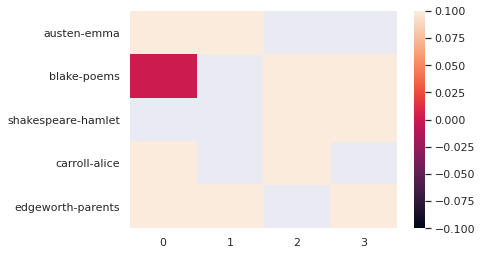

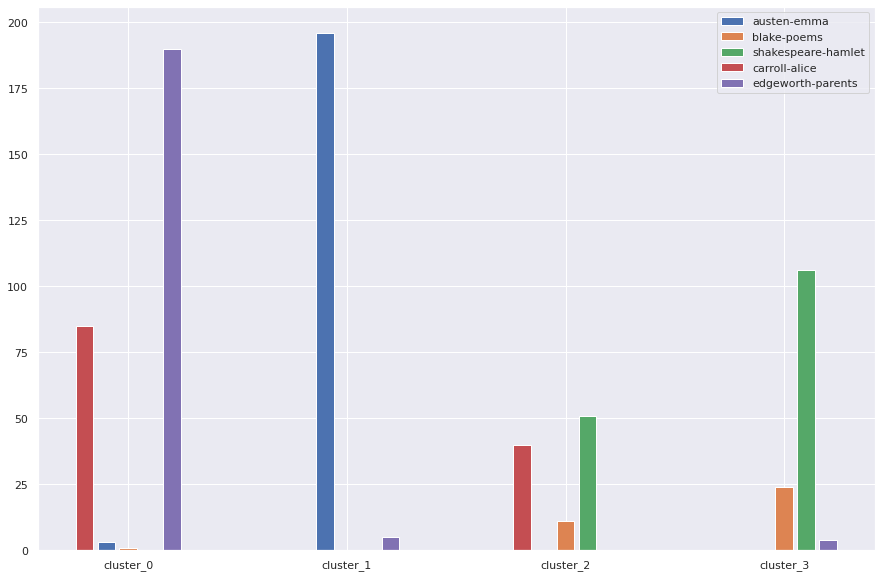

,0,1,2,3,label
0,3,196,0,0,austen-emma
1,1,0,11,24,blake-poems
2,0,0,51,106,shakespeare-hamlet
3,85,0,40,0,carroll-alice
4,190,5,0,4,edgeworth-parents


In [ ]:
cluster_labels_dist_plot(prediction_gmm , books_df.book_name)

In [ ]:
labels_tfidf=map_actual_labels(prediction_gmm,books_df.book_name)

 **Evaluation**

In [ ]:
from sklearn.metrics import homogeneity_score
from scipy.stats import spearmanr

In [ ]:
  ## Homogeneity scores: a cluster should contain only samples belonging to a single class
  print("Homogeneity score: ",np.round(metrics.homogeneity_score(books_df.book_name,labels_tfidf),2))

  ## Completeness score: if all the data points that are members of a given class are elements of the same cluster
  print("Completeness score: ",np.round( metrics.completeness_score(books_df.book_name, labels_tfidf),2))

  ##The V-Measure is defined as the harmonic mean of homogeneity and completeness
  print("V-measure score: ",np.round( metrics.v_measure_score(books_df.book_name ,labels_tfidf),2))

  ## The Rand Index computes a similarity measure between two clusterings by considering all pairs 
  print("Adjusted rand score: ",np.round( metrics.adjusted_rand_score(books_df.book_name,labels_tfidf),2))

  ## Cohen’s kappa: a statistic that measures inter-annotator agreement
  print("Kappa score: ",np.round( metrics.cohen_kappa_score(books_df.book_name, labels_tfidf,weights='linear'),2))

  ##The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample
  print("Silhouette score: ",np.round( metrics.silhouette_score(Y_sklearn, labels_tfidf),2))

  ## Calculate a Spearman correlation coefficient with associated p-value.
  print("Correlation: ",str(spearmanr(books_df.book_name,labels_tfidf)))  

Homogeneity score:  0.6
Completeness score:  0.82
V-measure score:  0.69
Adjusted rand score:  0.64
Kappa score:  0.76
Silhouette score:  0.54
Correlation:  SpearmanrResult(correlation=0.7728323432520907, pvalue=3.771397628276423e-143)


# Gaussian Model on BOW

**Decide the n_components based on the AIC and BIC**

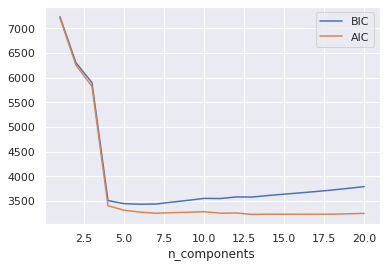

In [ ]:
n_components(bow)

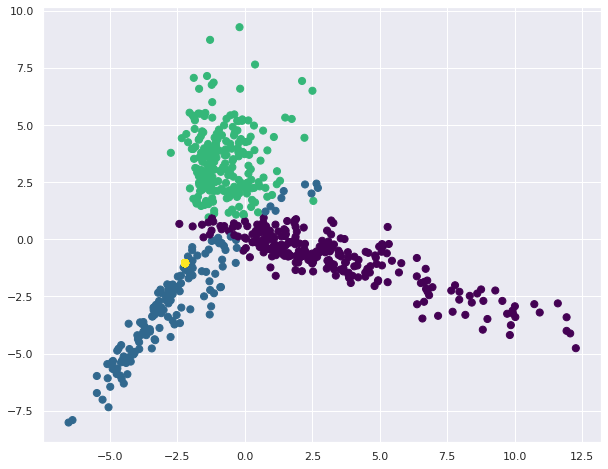

In [ ]:
# Reduce feacture vectors using PCA to 2-components 2D
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(bow.toarray())
#n_components relate to number of clusters n_components=9 according to the AIC & BIC method
gmm = GaussianMixture(n_components=4, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')





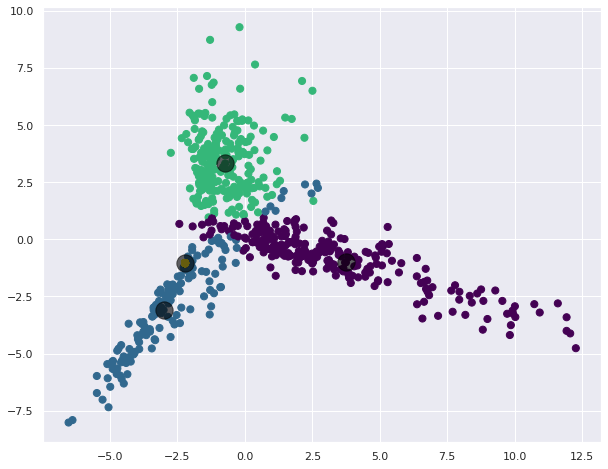

In [ ]:
#Highlight the centroid position for each cluster
centers = np.zeros((4,2))
for i in range(4):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

**Human vs Model**

Compare and decide which clustering result is the closest to the human labels, according to the highest percent means the best cluster according to the actual clusters

In [ ]:
get_clusters_label(prediction_gmm,books_df.book_name)

actual_labels
clusters actual_labels                    
0        edgeworth-parents       64.919355
         carroll-alice           33.870968
         blake-poems              0.806452
         austen-emma              0.403226
1        shakespeare-hamlet      70.198675
         blake-poems             15.894040
         edgeworth-parents       10.596026
         austen-emma              2.649007
         carroll-alice            0.662252
2        austen-emma             89.814815
         edgeworth-parents       10.185185
3        shakespeare-hamlet      50.495050
         carroll-alice           39.603960
         blake-poems              9.900990

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(prediction_gmm,books_df.book_name)))

,cluster,label,percentage
0,0,edgeworth-parents,64.919355
1,1,shakespeare-hamlet,70.198675
2,2,austen-emma,89.814815
3,3,shakespeare-hamlet,50.495050


**Error Analysis**

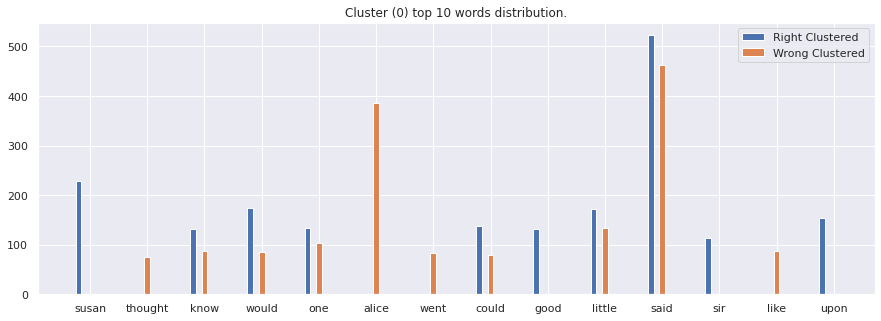

Top 10 words in the right clustered
 [('said', 522), ('susan', 228), ('would', 174), ('little', 173), ('upon', 154), ('could', 138), ('one', 133), ('good', 132), ('know', 132), ('sir', 113)]

Top 10 words in the wrong clustered
 [('said', 463), ('alice', 385), ('little', 134), ('one', 103), ('like', 88), ('know', 88), ('would', 85), ('went', 83), ('could', 79), ('thought', 76)]

Found 6 words in both right and wrong clustered top words [('said', 463), ('little', 134), ('one', 103), ('know', 88), ('would', 85), ('could', 79)]




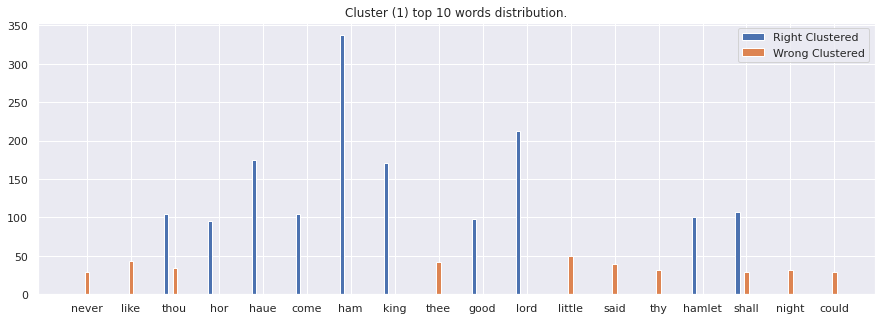

Top 10 words in the right clustered
 [('ham', 337), ('lord', 212), ('haue', 175), ('king', 171), ('shall', 107), ('thou', 105), ('come', 104), ('hamlet', 100), ('good', 98), ('hor', 95)]

Top 10 words in the wrong clustered
 [('little', 50), ('like', 44), ('thee', 42), ('said', 40), ('thou', 34), ('thy', 31), ('night', 31), ('could', 29), ('never', 29), ('shall', 29)]

Found 2 words in both right and wrong clustered top words [('thou', 34), ('shall', 29)]




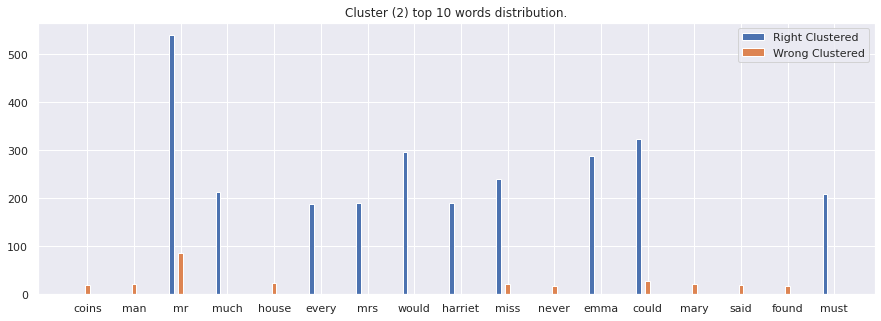

Top 10 words in the right clustered
 [('mr', 539), ('could', 323), ('would', 297), ('emma', 287), ('miss', 241), ('much', 214), ('must', 209), ('mrs', 191), ('harriet', 191), ('every', 187)]

Top 10 words in the wrong clustered
 [('mr', 85), ('could', 27), ('house', 23), ('mary', 22), ('miss', 22), ('man', 21), ('coins', 20), ('said', 19), ('never', 18), ('found', 17)]

Found 3 words in both right and wrong clustered top words [('mr', 85), ('could', 27), ('miss', 22)]




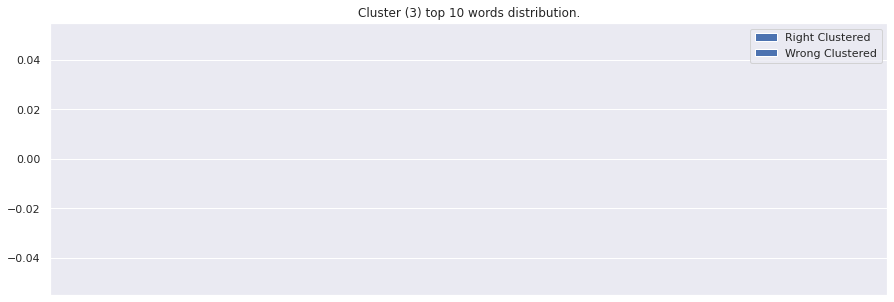

Top 10 words in the right clustered
 []

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




In [ ]:
top_frequent_analysis(prediction_gmm,books_df.book_name,books_df.partition)

/content/cluster_evaluate.py:129: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(all_label_dist_df[[i for i in range(0,num_clusters)]]) , yticklabels=all_label_dist_df['label'])


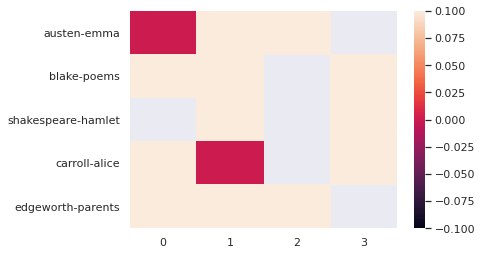

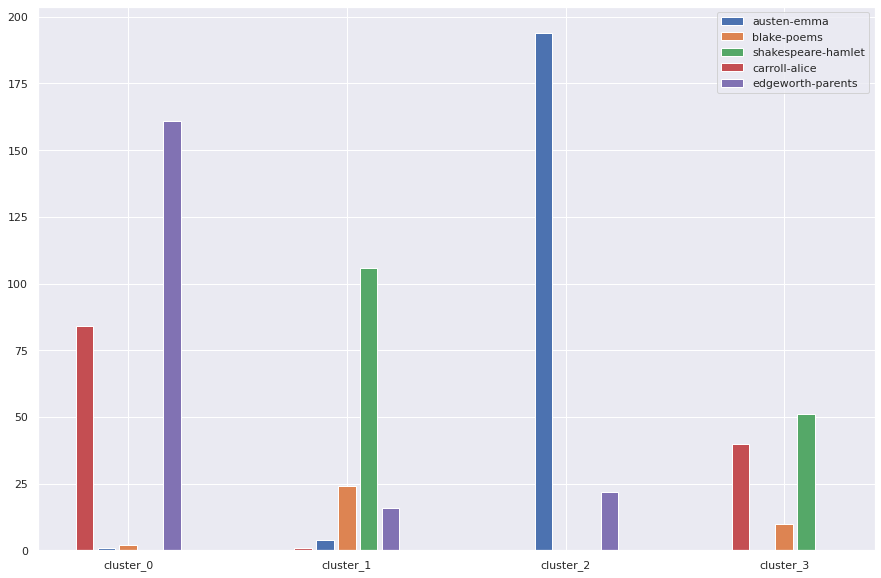

,0,1,2,3,label
0,1,4,194,0,austen-emma
1,2,24,0,10,blake-poems
2,0,106,0,51,shakespeare-hamlet
3,84,1,0,40,carroll-alice
4,161,16,22,0,edgeworth-parents


In [ ]:
cluster_labels_dist_plot(prediction_gmm , books_df.book_name)

In [ ]:
labels_bow=map_actual_labels(prediction_gmm,books_df.book_name)

 **Evaluation**

In [ ]:
from sklearn.metrics import homogeneity_score
from scipy.stats import spearmanr

In [ ]:
  ## Homogeneity scores: a cluster should contain only samples belonging to a single class
  print("Homogeneity score: ",np.round(metrics.homogeneity_score(books_df.book_name,labels_bow),2))

  ## Completeness score: if all the data points that are members of a given class are elements of the same cluster
  print("Completeness score: ",np.round( metrics.completeness_score(books_df.book_name, labels_bow),2))

  ##The V-Measure is defined as the harmonic mean of homogeneity and completeness
  print("V-measure score: ",np.round( metrics.v_measure_score(books_df.book_name ,labels_bow),2))

  ## The Rand Index computes a similarity measure between two clusterings by considering all pairs 
  print("Adjusted rand score: ",np.round( metrics.adjusted_rand_score(books_df.book_name,labels_bow),2))

  ## Cohen’s kappa: a statistic that measures inter-annotator agreement
  print("Kappa score: ",np.round( metrics.cohen_kappa_score(books_df.book_name, labels_bow,weights='linear'),2))

  ##The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample
  print("Silhouette score: ",np.round( metrics.silhouette_score(Y_sklearn, labels_bow),2))

  ## Calculate a Spearman correlation coefficient with associated p-value.
  print("Correlation: ",str(spearmanr(books_df.book_name,labels_bow)))  

Homogeneity score:  0.51
Completeness score:  0.7
V-measure score:  0.59
Adjusted rand score:  0.55
Kappa score:  0.7
Silhouette score:  0.51
Correlation:  SpearmanrResult(correlation=0.7303629761080849, pvalue=2.595058013464422e-120)
